<a id='sec0'></a>
# Predictive annotation of quantification methods with Noun Chunks 4 (with re-processed corpora)
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec1'><b>Data preparation</b></a>
- <a href='#sec2'><b>NLP</b></a>
- <a href='#sec3'><b>Classification (Initial)</b></a>
- <a href='#sec4'><b>Classification (Deeper)</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy

from nltk.corpus import stopwords
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

<a id='sec1-1'></a>
#### 1. Read in data and process df

In [3]:
with open('nlp15_data/dfs/all_fields_nchunks_df_quant_dummies2.pickle', 'rb') as infile_df:
    df = pickle.load(infile_df)

protocols_tfidf = corpora.MmCorpus('nlp15_data/bow_and_tfidf/protocols_tfidf_nchunks2.mm')
whole_tfidf = corpora.MmCorpus('nlp15_data/bow_and_tfidf/whole_tfidf_nchunks2.mm')

my_dictionary = corpora.Dictionary.load('nlp15_data/whole_dictionary_nchunks2.dict')
print(my_dictionary)

Dictionary(107063 unique tokens: ['activation', 'aggressive tumor phenotype', 'alkylation', 'annotated peptide spectra', 'another group']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,instruments,exp_types,quant_methods,labhead_fullname,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast cancer tissue lysates, reduction, alky...","[proteomics data, proteome discoverer, fdr<0.0...","[current prognostic factors, precise risk-disc...",LTQ Orbitrap Velos,Shotgun proteomics,itraq,Pavel Bouchal,0,0,0,0,1,0
1,PXD000164,"[protein extraction, catheter biofilm small pi...","[tryptic digest, reversed phase, chromatograph...","[term-catheterization, catheter-associated bac...",LTQ Orbitrap Velos,Shotgun proteomics,label free,Katharina Riedel,0,0,0,0,0,1


In [5]:
len(df), len(protocols_tfidf), len(whole_tfidf), len(my_dictionary)

(2387, 2387, 2387, 107063)

<a id='sec3'></a>
## Classification (initial)
<a href='#sec0'>(Back to top)</a><br><br>
<i>Here, I'll focus on binary classification for each category. For example, one task would be to distinguish 'silac' from everything else. Ideally, it should be multi-class classification, but since a dataset can contain multiple quantification methods, for now, I'll stick with yes/no type binary classification for each quantification method that I picked. Here, I'll use Tf-Idf vectors only and take a quick look at the performance of different classifiersvisually with ROC curves. </i><br>
<br>
Classifiers to try: MultinomialNB, Logistic Regression, Random Forest (and SVM maybe?)<br>
<br>
For each classifier for each text set for each type of word vectors for each quantification type:
1. Split into train/test with a fixed random_state for comparison
2. Run vanilla classifier without much hyperparameter tuned and plot ROC curves

#### Loading data

In [29]:
def classify(corpus, target, num_terms=22736, test_size=0.2, random_state=777):
    # Set features and y
    x = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    # Classifiers to test
    classifiers = {
    'MultinomialNB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=1000, penalty='l2'),
    'Random Forest': RandomForestClassifier(n_jobs=8, n_estimators=300, max_depth=20)
    }

    results = {}
    for name, clf in classifiers.items():
        result = {}
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['report'] = report
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        results[name] = result
    return results


def multiple_classify(my_corpora, target, target_labe=None, num_terms=22736, test_size=0.2, random_state=777):
    fig = plt.figure(figsize=(12, 8))
    t = np.linspace(0, 1, 10)
    ax_pos = 1

    for corpus_name, corpus in my_corpora.items():
        results = classify(corpus, target, num_terms=num_terms)

        ax = fig.add_subplot(2, 3, ax_pos)
        ax.plot(t, t, ls='--', lw=0.5, color='0.4')
        for k, v in results.items():
            #print('='*5, 'Report for %s' % k, '='*10)
            #print(v['report'])
            fpr = v['fpr']
            tpr = v['tpr']
            auc = v['roc_auc']
            ax.plot(fpr, tpr, label=('%s (AUC=%.2f)' % (k, auc)))
        ax.legend()
        ax.set_xlabel('False Positive Rate')#, fontsize=14)
        ax.set_ylabel('True Positive Rate')#, fontsize=14)
        a = ax.set_title('Annotating \'%s\'\nby %s' % (target_labe, corpus_name))#, fontsize=14)
        ax_pos += 1

    fig.tight_layout()

In [7]:
my_corpora = {
    'protocols': protocols_tfidf,
    'all_combined': whole_tfidf
}

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


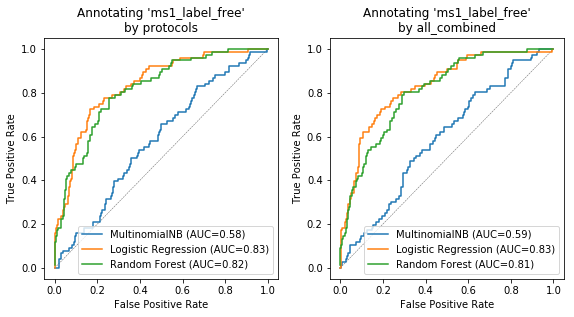

In [30]:
multiple_classify(my_corpora, df.ms1_label_free, target_labe='ms1_label_free', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


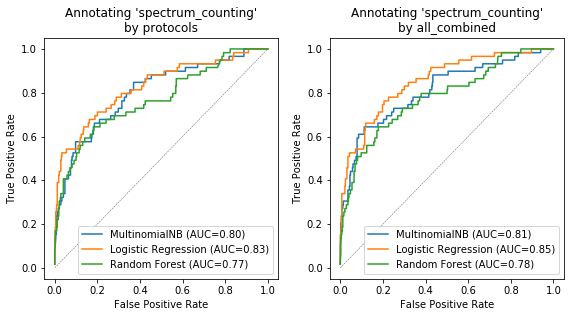

In [31]:
multiple_classify(my_corpora, df.spectrum_counting, target_labe='spectrum_counting', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


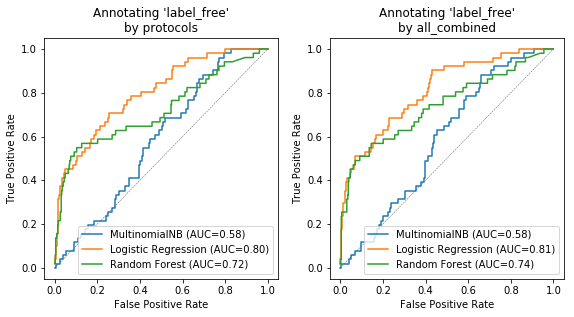

In [32]:
multiple_classify(my_corpora, df.label_free, target_labe='label_free', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

##### Easier ones

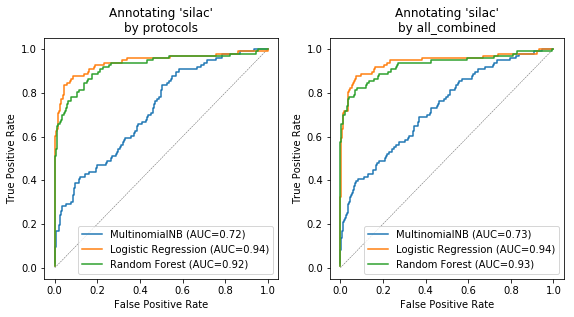

In [33]:
multiple_classify(my_corpora, df.silac, target_labe='silac', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


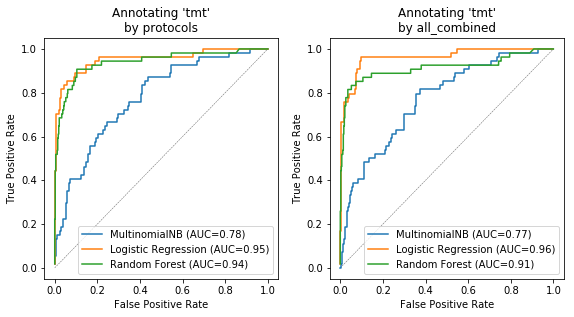

In [34]:
multiple_classify(my_corpora, df.tmt, target_labe='tmt', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


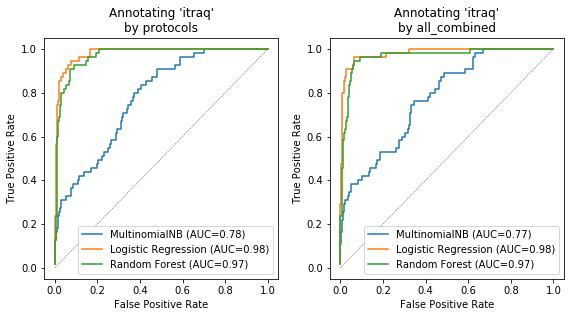

In [35]:
multiple_classify(my_corpora, df.itraq, target_labe='itraq', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

In [40]:
if True:
    protocols_tfidf_uni = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    whole_tfidf_uni = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary_uni = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')

In [37]:
len(protocols_tfidf_uni), len(whole_tfidf_uni)

(2387, 2387)

In [45]:
protocols_x1 = matutils.corpus2dense(protocols_tfidf_uni, num_terms=len(my_dictionary_uni)).T
protocols_x2 = matutils.corpus2dense(protocols_tfidf, num_terms=len(my_dictionary)).T
X1 = np.concatenate((protocols_x1, protocols_x2), axis=1)

whole_x1 = matutils.corpus2dense(whole_tfidf_uni, num_terms=len(my_dictionary_uni)).T
whole_x2 = matutils.corpus2dense(whole_tfidf, num_terms=len(my_dictionary)).T
X2 = np.concatenate((whole_x1, whole_x2), axis=1)

In [46]:
X1.shape, X2.shape

((2387, 129799), (2387, 129799))

In [48]:
def classify2(x, target, num_terms=22736, test_size=0.2, random_state=777):
    # Set features and y
    y = np.array(target)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    # Classifiers to test
    classifiers = {
    'MultinomialNB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=1000, penalty='l2'),
    'Random Forest': RandomForestClassifier(n_jobs=8, n_estimators=300, max_depth=20)
    }

    results = {}
    for name, clf in classifiers.items():
        result = {}
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['report'] = report
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        results[name] = result
    return results


def multiple_classify2(my_corpora, target, target_labe=None, num_terms=22736, test_size=0.2, random_state=777):
    fig = plt.figure(figsize=(12, 8))
    t = np.linspace(0, 1, 10)
    ax_pos = 1

    for corpus_name, corpus in my_corpora.items():
        results = classify2(corpus, target, num_terms=num_terms)

        ax = fig.add_subplot(2, 3, ax_pos)
        ax.plot(t, t, ls='--', lw=0.5, color='0.4')
        for k, v in results.items():
            #print('='*5, 'Report for %s' % k, '='*10)
            #print(v['report'])
            fpr = v['fpr']
            tpr = v['tpr']
            auc = v['roc_auc']
            ax.plot(fpr, tpr, label=('%s (AUC=%.2f)' % (k, auc)))
        ax.legend()
        ax.set_xlabel('False Positive Rate')#, fontsize=14)
        ax.set_ylabel('True Positive Rate')#, fontsize=14)
        a = ax.set_title('Annotating \'%s\'\nby %s' % (target_labe, corpus_name))#, fontsize=14)
        ax_pos += 1

    fig.tight_layout()

In [49]:
my_corpora2 = {
    'protocols': X1,
    'all_combined': X2
}

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


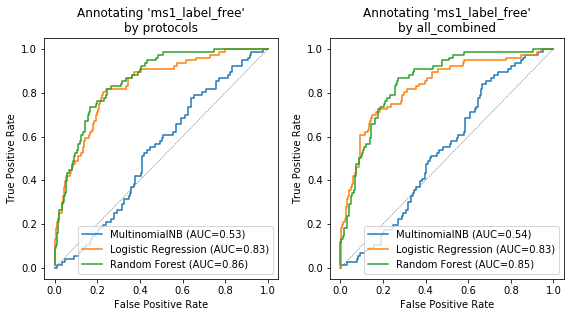

In [50]:
multiple_classify2(my_corpora2, df.ms1_label_free, target_labe='ms1_label_free', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


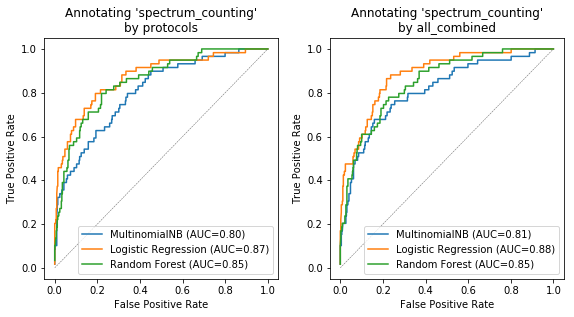

In [51]:
multiple_classify2(my_corpora2, df.spectrum_counting, target_labe='spectrum_counting', num_terms=len(my_dictionary), test_size=0.2, random_state=777)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


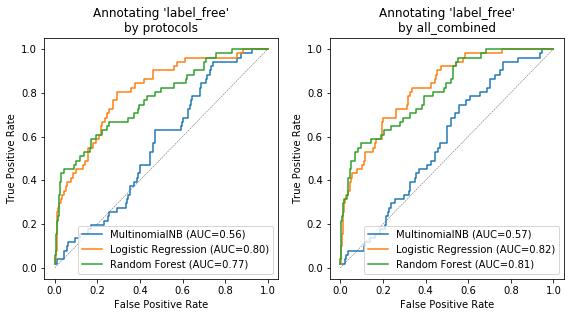

In [52]:
multiple_classify2(my_corpora2, df.label_free, target_labe='label_free', num_terms=len(my_dictionary), test_size=0.2, random_state=777)